In [1]:

from fastai.vision.all import *


set_seed(42)

path_ori = Path('/kaggle/input/clothing-dataset-full/images_original')
path_comp = Path('/kaggle/input/extracting-attributes-from-fashion-images-2/train')


In [2]:
import pandas as pd

In [3]:
img_csv = pd.read_csv('/kaggle/input/extracting-attributes-from-fashion-images-2/train.csv')

In [4]:
train_path = '/kaggle/input/extracting-attributes-from-fashion-images-2/train'
train_files = get_image_files(train_path)

test_path = '/kaggle/input/extracting-attributes-from-fashion-images-2/test'
test_files = get_image_files(test_path).sorted()


train_df = pd.read_csv('/kaggle/input/extracting-attributes-from-fashion-images-2/train.csv')
train_df.head()

,file_name,label
0,Image_train_00001.jpg,0
1,Image_train_00002.jpg,1
2,Image_train_00003.jpg,0
3,Image_train_00004.jpg,0
4,Image_train_00005.jpg,0


In [5]:
train_df.dtypes

file_name    object
label         int64
dtype: object

In [6]:
blocks = (ImageBlock, CategoryBlock)
blocks

(<function fastai.vision.data.ImageBlock(cls: 'PILBase' = <class 'fastai.vision.core.PILImage'>)>,
 <function fastai.data.block.CategoryBlock(vocab: 'MutableSequence | pd.Series' = None, sort: 'bool' = True, add_na: 'bool' = False)>)

In [7]:
get_x = ColReader("file_name", pref=(path_comp))
get_y = ColReader("label")
get_x
get_y

ColReader -- {'cols': 'label', 'pref': '', 'suff': '', 'label_delim': None}:
encodes: decodes: 

In [8]:
from PIL import Image
image = Image.open('/kaggle/input/extracting-attributes-from-fashion-images-2/train/Image_train_00003.jpg')
width, height = image.size
width

400

In [9]:
height

533

In [10]:
from PIL import Image
image = Image.open('/kaggle/input/extracting-attributes-from-fashion-images-2/test/Image_test_00003.jpg')
width, height = image.size
width

400

In [11]:
height

533

In [12]:
tfms = aug_transforms(do_flip=True, flip_vert=True, max_rotate=0.10, max_zoom=1.3, max_warp=0.0)


In [13]:
dblock = DataBlock(blocks=blocks, 
                    get_x=get_x,
                    get_y=get_y,
                   item_tfms=Resize(224,method='squish'),
                   batch_tfms=tfms,splitter=RandomSplitter(valid_pct=0.2, seed=42))
dblock


In [14]:
aug_transforms?

Signature:
aug_transforms(
    mult: 'float' = 1.0,
    do_flip: 'bool' = True,
    flip_vert: 'bool' = False,
    max_rotate: 'float' = 10.0,
    min_zoom: 'float' = 1.0,
    max_zoom: 'float' = 1.1,
    max_lighting: 'float' = 0.2,
    max_warp: 'float' = 0.2,
    p_affine: 'float' = 0.75,
    p_lighting: 'float' = 0.75,
    xtra_tfms: 'list' = None,
    size: 'int | tuple' = None,
    mode: 'str' = 'bilinear',
    pad_mode='reflection',
    align_corners=True,
    batch=False,
    min_scale=1.0,
)
Docstring: Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms.
File:      /opt/conda/lib/python3.10/site-packages/fastai/vision/augment.py
Type:      function

In [16]:
dls = dblock.dataloaders(img_csv)
dls

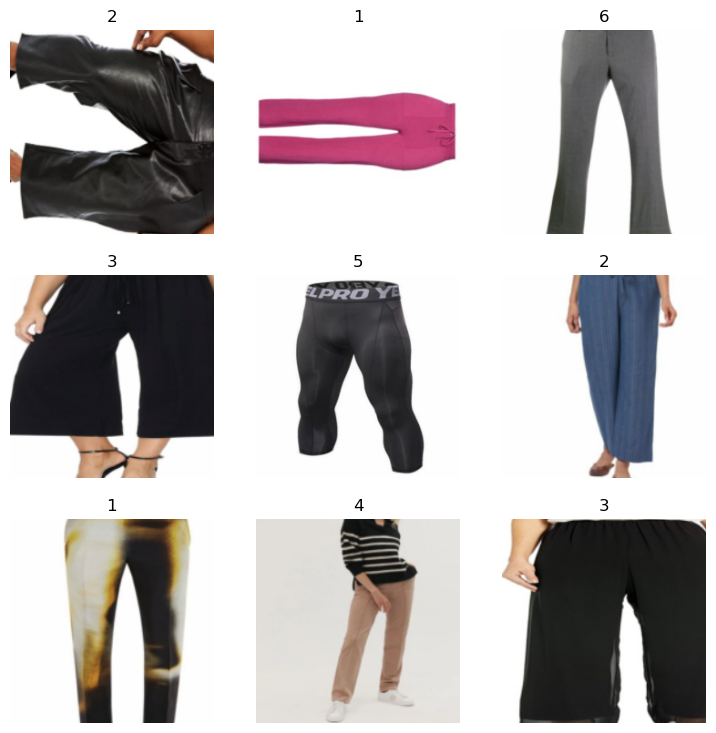

In [17]:
dls.show_batch()

In [18]:
import tensorflow

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='valid_loss', patience=2,restore_best_weights=True)

In [ ]:
learn = vision_learner(dls, resnet50, metrics=accuracy,pool=nn.AdaptiveAvgPool2d,ps=0.5,cut=-2)

learn


In [21]:
from fastai.vision import *

learn = vision_learner(dls, resnet34, metrics=accuracy)

# Define the dense layer
dense_layer = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(512, 7)  # Adjust the input size based on the architecture used
)

# Replace the head of the learner with the dense layer
learn.model[1] = dense_layer

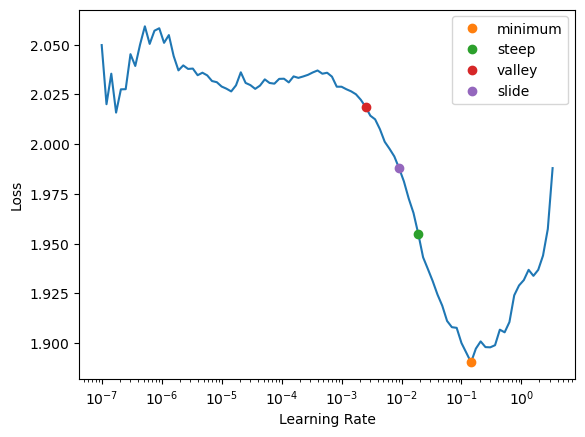

In [22]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
learn.fit_one_cycle(3,lrs.valley)

epoch,train_loss,valid_loss,accuracy,time
0,1.379718,1.143907,0.570691,03:42


In [ ]:
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [23]:
learn.fit_one_cycle(12,slice(lrs.minimum,lrs.slide))

epoch,train_loss,valid_loss,accuracy,time
0,1.062813,0.908800,0.641925,03:50
1,1.057936,0.959621,0.630506,03:56
2,1.031908,0.829325,0.669657,03:48
3,0.904127,0.818679,0.668842,03:48
4,0.851932,0.783414,0.688146,03:45
5,0.768541,0.760378,0.693312,03:46
6,0.691910,0.761629,0.700924,03:45
7,0.661563,0.752222,0.696302,03:44
8,0.591206,0.765007,0.699293,03:44
9,0.569005,0.759039,0.715063,03:45


In [ ]:
learn.fine_tune(10,0.001737800776027143)

In [ ]:
probs, target = learn.get_preds(dl=dls.valid)
error_rate(probs, target)

In [ ]:
probs, target = learn.tta(dl=dls.valid)
error_rate(probs, target)

In [24]:
probs, _ = learn.tta(dl=dls.test_dl(test_files))

In [25]:
preds = probs.argmax(dim=1)


In [26]:
dls.vocab[preds]


(#5751) [2,4,2,1,2,2,4,2,2,2...]

In [27]:
sample_submission=pd.read_csv('/kaggle/input/extracting-attributes-from-fashion-images-2/sample_submission.csv')

In [28]:
sample_submission.shape

(5751, 2)

In [29]:
sample_submission.label = dls.vocab[preds]


In [30]:
import pandas

In [31]:
import numpy

In [32]:
sample_submission.to_csv('11.csv',index=False)


In [ ]:
FileLink("1101.csv")